# Clipping as a function

In [1]:
import numpy as np 
import quaternion
from quaternion_matrix import quatmatmul_matrix_by_matrix
from quaternion_circulant_matrix import quaternionic_circulant_filter
from quaternion_symplectic import symplectic_decomposition, symplectic_synthesis
from quaternion_symplectic import qfft, iqfft, load_image, get_modulus_phase_axis, vis
from quaternion_symplectic import qfft_eigenvalues, iqfft_eigenvalues, vis
from quaternion_matrix import quatdotproduct, eigdecomposition, qsvd, qsvd_synthesis
from circulant import pad_to_size
np.set_printoptions(precision=2, suppress=True)  # for compact output

def create_sets_of_doublyblock_given_filter(C_filter):
    N, _, M = C_filter.shape
    C = np.zeros([N*N, N*N, M], dtype=np.quaternion)
    for c in range(M):
        # For M=16, N=32 this will take ~25sec on pythagoras
        C[:, :, c] = quaternionic_circulant_filter(C_filter[:, :, c])
    return(C)


In [2]:
def compute_singular_values(kernel, inputimage_sidesize=None, mu=None):
    '''
    Computes s.vs of a (N, N, M) sized kernel (stack of M filters of NxN 2D size)
    The kernel is meant to be applied for "depthwise" convolution, ie the filters are applied independently from one another on the input.
    '''
    return(
        clip_quaternionic_convolutional_layer(kernel=kernel,
                                              inputimage_sidesize=inputimage_sidesize,
                                              clipping_value=None,
                                              mu=mu,
                                              return_floatarray=False,
                                              just_compute_singular_values=True,
                                              bruteforce_svd=False)
    )


def clip_quaternionic_convolutional_layer(kernel, 
                                          inputimage_sidesize,                          # Dont do any padding if =None
                                          clipping_value=None,
                                          mu=None,                                      # The axis of the qft transform
                                          return_floatarray=False,                      # Return object with last dim = 4
                                          just_compute_singular_values=False,           # 
                                          bruteforce_svd=False,                         # Don't use any of our theoretical results
                                          xi_type='new'
                                          ):
    '''
    With input a quaternionic convolutional kernel,
    this function implements two things:
    
    a) Computing of singular values of the kernel.
    b) Clipping of the singular values wrt to a user-provided threshold, and reconstruct the filter.
    
    The kernel must correspond to M filters of size NxN.
    Each input channel is filtered by a separate filter, leading to one output channel.
    This is a ``depthwise'' convolution [Chollet 2017, "Xception: Deep Learning with Depthwise Separable Convolutions", CVPR 2017]

            
    Input:
       kernel                   A non-zero padded kernel, of float_array type.
                                Dimensions: NxNxMx4
       inputimage_sidesize      The size of the side of the (square) input.
                                Zero-padding will be performed.
       clipping_value           Singular values will be clipped to this value.
       mu                       Axis of transforms. (Default: ~ i+j+k)
       xi_type                  'new' or 'old'. Refers to the structure of the 'Xi' matrix.
                                'old' is the one presented in the arXiv version, 'new' is default.
    Output:
       C_filter_clipped        The clipped kernel, same size as input.

       
    If just_compute_singular_values is set:
        Sigma                   The (sorted) singular values
    
    If bruteforce_svd is set:
        Sigma                   The (sorted) singular values
        C                       The block-doubly block circulant matrix representation of the kernel

    '''
    def matmul_quaternionXreal(K, A):
        M, N = K.shape
        Ma, Na = A.shape
        assert(Ma == N)
        Kfloat = quaternion.as_float_array(K)
        res = np.zeros([M, Na, 4])
        for i in range(4):
            res[:, :, i] = Kfloat[:, :, i] @ A
        return(quaternion.as_quat_array(res))

    def compute_indexpair_information(N):
        # Check which blocks are 1x1, which are 2x2.
        # Approximately half the 2x2 are "redundant"; ie they contain the same information as another block.
        # This will need to be taken into consideration.
        # (Almost) all indices \in [1,N*N] will have their "pair". This is given by the structure of Q*kronecker*Q.    
        # The "Pvec" array will information about which index pairs with which.
        # Pvec[i] = j means that index i forms a 2x2 block with index j.
        # The "*_permuted" names later on, are structures which have had their indices permuted so that
        # the indices of "Pvec" are consecutive.
        Pvec = np.zeros([N*N,], dtype=np.uint32)
        for i in range(N):
            for j in range(N):
                col = i + j*N
                row = (N-i)%N + N*((N-j)%N)
                Pvec[col] = row

        blockindices_1x1 = []
        blockindices_redundant = np.zeros([N*N,])
        blockindices_nonredundant = np.zeros([N*N,])
        for i in range(N*N):
            if(Pvec[i] == i):
                blockindices_1x1.append(i)
                blockindices_nonredundant[i] = 1
                continue
            if(blockindices_redundant[i] == 1):
                blockindices_nonredundant[i] = 1
                continue
            blockindices_redundant[Pvec[i]] = 1
        blockindices_redundant = list(np.nonzero(blockindices_redundant)[0])
        blockindices_nonredundant = list(np.nonzero(blockindices_nonredundant)[0])
        assert(len(blockindices_1x1) <= 4)          # Maximum 4 in the 2D case
        assert(len(blockindices_redundant) + len(blockindices_nonredundant) == N*N)
        return(Pvec, blockindices_1x1, blockindices_redundant, blockindices_nonredundant)

    def decompose_left_eigenvalues(C_eigenvalues):
        #C_eigenvalues_permuted = np.zeros([N*N, M], dtype=np.quaternion)
        #simplex_part_permuted = np.zeros([N*N, M], dtype=np.quaternion)
        #perplex_part_permuted = np.zeros([N*N, M], dtype=np.quaternion)
        #simplex_part = np.zeros([N*N, M], dtype=np.quaternion)
        #perplex_part = np.zeros([N*N, M], dtype=np.quaternion)

        C_eigenvalues_permuted = C_eigenvalues[Pvec, :]
        # b. We need simplex / perplex decompositions for (almost) all left eigenvalues.
        C_eigenvalues_ravelled = np.reshape(C_eigenvalues, [-1, M])
        (simplex_part, tt), (_, mu2, _) = symplectic_decomposition(C_eigenvalues_ravelled, mu1=mu, save_true_values=True); perplex_part = tt * mu2
        simplex_part = np.reshape(simplex_part, [-1, M])
        perplex_part = np.reshape(perplex_part, [-1, M])
        simplex_part_permuted = simplex_part[Pvec, ...]
        perplex_part_permuted = perplex_part[Pvec, ...]
        return(simplex_part, perplex_part, C_eigenvalues_permuted, simplex_part_permuted, perplex_part_permuted)

    def qsvd_batchdecompose(A, filter_range=None):
        '''
        A is shaped as (2, 2, N*N, M) 
        '''
        N2 = A.shape[2]
        M = A.shape[3]
        if filter_range is None:
            filter_range = range(N2)

        ttUaux = np.zeros([2, 2, N2, M])
        ttSigma = np.zeros([2, N2, M])
        ttVHaux = np.zeros([2, 2, N2, M])
        ttLH = np.zeros([2, 2, N2, M], dtype=np.quaternion)
        ttRH = np.zeros([2, 2, N2, M], dtype=np.quaternion)
        for i in filter_range:
            for c in range(M):
                ttLH[:, :, i, c], ttUaux[:, :, i, c], ttSigma[:, i, c], ttVHaux[:, :, i, c], ttRH[:, :, i, c] = qsvd(A[:, :, i, c], return_also_bidiagonalization=True)
        return(ttLH, ttUaux, ttSigma, ttVHaux, ttRH)

    def qsvd_batchreconstruct(ttLH, ttUaux, newSigma, ttVHaux, ttRH):
        '''
        Result is shaped as (2, 2, N*N, M) 
        '''
        N2 = ttLH.shape[2]
        M = ttLH.shape[3]
        res = np.zeros([2, 2, N*N, M], dtype=np.quaternion)
        for i in range(N2):
            for c in range(M):
                res[:, :, i, c] = quatmatmul_matrix_by_matrix(
                    matmul_quaternionXreal(ttLH[:, :, i, c], ttUaux[:, :, i, c] @ np.diag(newSigma[:, i, c]) @ ttVHaux[:, :, i, c]), 
                    ttRH[:, :, i, c], fast_version=True)
        return(res)

    ##################################################################################################################################################

    if(not just_compute_singular_values and xi_type == 'old'):
        raise ValueError('You must use the "old" Xi matrix only to compute singular values.')
    if(not just_compute_singular_values and clipping_value is None):
        raise ValueError('You must specify a clipping value, or just ask for the singular values.')

    if(type(kernel.flat[0]) == np.quaternion):
        kernel = quaternion.as_float_array(kernel)

    assert(len(kernel.shape) == 4)
    assert(kernel.shape[-1] == 4)
    Noriginal_1, Noriginal_2, M, _ = kernel.shape
    #
    # Apply zero-padding if necessary
    #
    if(inputimage_sidesize is not None):
        N = inputimage_sidesize
        C_filter_float = np.zeros([N, N, M, 4])
        for b in range(4):
            for c in range(M):
                C_filter_float[:, :, c, b] = pad_to_size(kernel[:, :, c, b], N, N)
        
        C_filter = quaternion.as_quat_array(C_filter_float)
    else:
        # Don't apply zeropadding
        N = Noriginal_1
        assert(Noriginal_1 == Noriginal_2)
        C_filter = quaternion.as_quat_array(kernel)

    #
    # If bruteforce_svd is True,
    # Compute set of doubly-block circulant matrices.
    # Note, this is the same as having a block diagonal matrix with doubly-block circulant blocks.
    #
    if(bruteforce_svd):
        if(M > 16 or N > 64):
            raise ValueError("Please specify lower values for M (max:16) and N(max:64). This option is too expensive.")

        C = np.zeros([N*N*M, N*N*M], dtype=np.quaternion)
        for c in range(M):
            for d in range(M):
                # Force output to be block-diagonal, with doubly-block circulant blocks.
                if d != c:      #kept this code like this bc it'll come in handy when we deal with true multifilter cases
                    continue 
                startindex_i = c*N*N
                endindex_i = (c+1)*N*N
                startindex_j = d*N*N
                endindex_j = (d+1)*N*N
                C[startindex_i:endindex_i, startindex_j:endindex_j] = quaternionic_circulant_filter(C_filter[:, :, c])
        # END FOR
        L, U, Sigma, V, R = qsvd(C, return_also_bidiagonalization=True)
        if(just_compute_singular_values):
            return(np.sort(Sigma), C)
        newSigma = np.clip(Sigma, None, clipping_value)        
        C_clipped = quatmatmul_matrix_by_matrix(
                    matmul_quaternionXreal(L, U @ np.diag(newSigma) @ V), 
                    R, fast_version=True)
        return(np.sort(newSigma), C_clipped)

    if(mu is None):
        #mu = np.quaternion(0, np.random.randn(1), np.random.randn(1), np.random.randn(1)).normalized()
        mu = np.quaternion(0, 1, 1, 1).normalized()
    ########################################################################################################
    # Step 1: Compute left eigenvalues given some choice of mu (multiple mus maybe tried later on)
    # Compute LEFT eigenvalues for all filters
    C_eigenvalues = np.zeros([N*N, M], dtype=np.quaternion)
    for c in range(M):
        # Takes 3sec for M=64,N=32 on ibsen
        # TODO: Work on batch version 
        # TODO: Special case for qft_axis = i: simplex/perplex decomposition and synthesis is trivial in this case
        C_eigenvalues[:, c] = qfft_eigenvalues(C_filter[:, :, c], qft_axis=mu).ravel()    #use ravel for 2D
    # Step 2: Compute Xi (for M > 1 we'll need Xi^{1/2} obligatorily)
    Pvec, blockindices_1x1, blockindices_redundant, blockindices_nonredundant = compute_indexpair_information(N)
    simplex_part, perplex_part, C_eigenvalues_permuted, simplex_part_permuted, perplex_part_permuted = decompose_left_eigenvalues(C_eigenvalues)
    Xi_4 = np.zeros([4, N*N, M], dtype=np.quaternion)
    if xi_type == 'new':
        Xi_4[0, ...] = simplex_part
        Xi_4[1, ...] = perplex_part_permuted
        Xi_4[2, ...] = perplex_part
        Xi_4[3, ...] = simplex_part_permuted
    elif xi_type == 'old':
        Xi_4[0, ...] = C_eigenvalues.conj() * C_eigenvalues
        Xi_4[1, ...] = simplex_part.conj()*perplex_part_permuted + perplex_part.conj()*simplex_part_permuted
        Xi_4[2, ...] = Xi_4[1, ...].conj()
        Xi_4[3, ...] = C_eigenvalues_permuted.conj() * C_eigenvalues_permuted
    else:
        raise ValueError('Incorrect xi_type, must by "new" or "old".')
    Xi_2x2 = np.reshape(Xi_4, [2, 2, N*N, M])
    # Some blocks (at most two in 1D, at most four in 2D) 
    # should be really 1x1 blocks, make sure they have elements for the 'second' eigenvalue zeroed-out
    for i in blockindices_1x1:
        Xi_2x2[1, 1, i, :] = np.quaternion(0, 0, 0, 0)
        Xi_2x2[0, 1, i, :] = np.quaternion(0, 0, 0, 0)

    LH, Uaux, Sigma, VHaux, RH = qsvd_batchdecompose(Xi_2x2)    #TODO Most probably we dont need to evaluate *all* filters (half are redundant)
    if(xi_type == 'old'):
        Sigma = np.sqrt(Sigma) # we actually need Xi^{1/2} in this case

    def compute_sorted_singular_values(Sigma, blockindices_nonredundant, blockindices_1x1):
        M = Sigma.shape[-1]
        tt = np.zeros([2*len(blockindices_nonredundant), M])
        for c in range(M):
            tt[:, c] = Sigma[:, blockindices_nonredundant, c].flatten()
        tt = tt.flatten()
        tt = np.sort(tt)
        return(tt[len(blockindices_1x1)*M:])

    sorted_singular_values = compute_sorted_singular_values(Sigma, blockindices_nonredundant, blockindices_1x1)

    if(just_compute_singular_values):
        return(sorted_singular_values)

    if(clipping_value < np.max(sorted_singular_values)):
        # Step 4: Clip singular values and reconstruct Xi.
        Xi_2x2_clipped = qsvd_batchreconstruct(LH, Uaux, np.clip(Sigma, None, clipping_value), VHaux, RH)
        # Step 5: Compute left eigenvalues that correspond to clipped singular values.
        # The (1,1) elements in Xi will have the index of the "sister" eigenvalues
        # (and a small "trick": copy 1,1 first because they contain a zero for 1x1 blocks, and will be overwritten correctly with the next line)
        C_eigenvalues_clipped = np.zeros_like(C_eigenvalues, dtype=np.quaternion)
        C_eigenvalues_clipped[Pvec[blockindices_nonredundant], :] = Xi_2x2_clipped[1, 1, blockindices_nonredundant, :] + Xi_2x2_clipped[0, 1, blockindices_nonredundant, :]
        # The (0,0) elements in Xi will have the correct index
        C_eigenvalues_clipped[blockindices_nonredundant, :] = Xi_2x2_clipped[0, 0, blockindices_nonredundant, :] + Xi_2x2_clipped[1, 0, blockindices_nonredundant, :]
        # Step 6: Reconstruct filter using new left eigenvalues.
        C_filter_clipped = np.zeros_like(C_filter)
        for c in range(M):
            tt = np.reshape(C_eigenvalues_clipped[:, c], [N, -1])
            C_filter_clipped[:, :, c] = iqfft_eigenvalues(tt, qft_axis=mu)
        # Postprocessing: Clip back to original spatial range
        res = C_filter_clipped[:Noriginal_1, :Noriginal_2, :]
    else:
        res = kernel.copy()
        if(not return_floatarray):
            res = quaternion.as_quat_array(res)
    if return_floatarray and type(res.flat[0]) == np.quaternion:
        res = quaternion.as_float_array(res)
    if not return_floatarray and type(res.flat[0]) != np.quaternion:
        res = quaternion.as_quat_array(res)

    # Return the clipped kernel and its singular values, old and new
    sorted_singular_values_clipped = compute_sorted_singular_values(np.clip(Sigma, None, clipping_value), blockindices_nonredundant, blockindices_1x1)
    return(res, sorted_singular_values, sorted_singular_values_clipped)

(256,)
578.0954967616074 11473.36182845246
**Compute singular values (our method) -- Runtime of 85 milliseconds.
**Compute singular values (brute force) -- Runtime of 1459 milliseconds.
(256,)
11473.361828452451
4000.0000000000036
**Clipping of a 16x16 filter (our method) -- Runtime of 123 milliseconds.


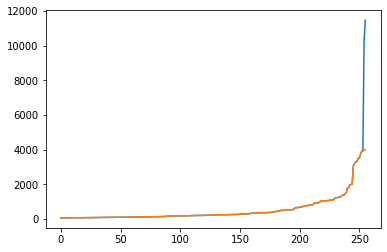

In [6]:
from timeit import default_timer as timer
from matplotlib import pyplot as plt
#
# a) Will create a 2D filter with pseudo-random values
#
visualize_filters = False
check_svs_are_correct = True
visualize_reconstruction = False
check_clipping_is_correct = False

def create_another_filter():
    N = 16
    C_filter = np.zeros([N, N, 1], dtype=np.quaternion)
    for i in range(N):
        for j in range(N):
            lm1 = np.cos(i)
            lm2 = np.sin(i)
            lm3 = np.cos(i+.3)
            lm4 = np.sin(i-.2)
            C_filter[i, j, 0] = np.quaternion(i+lm1/N, j+lm2/N, i*j*lm3, i*j*lm4)
    return(C_filter)

C_filter = create_another_filter()
N = C_filter.shape[0]
if visualize_filters: vis(C_filter[:, :, 0]), vis(C_filter[:, :, 0], visualization_style='channelwise')
#
# b) Compute its doubly-block circulant representation
#
C = quaternionic_circulant_filter(C_filter[:, :, 0])
if visualize_filters: vis(C)
#
# c) Compute singular values
#
start = timer()
singular_values = clip_quaternionic_convolutional_layer(C_filter, N, None, just_compute_singular_values=True)
end = timer()
print(singular_values.shape)
print(np.mean(singular_values), np.max(singular_values))
print(f'**Compute singular values (our method) -- Runtime of {int((end - start) * 1000)} milliseconds.')
#plt.plot(singular_values)

if check_svs_are_correct:
    # In case we want to check that singular values are indeed exact, uncomment the following:
    start = timer()
    singular_values_svd, C = clip_quaternionic_convolutional_layer(C_filter, N, None, just_compute_singular_values=True, bruteforce_svd=True)
    end = timer()
    print(f'**Compute singular values (brute force) -- Runtime of {int((end - start) * 1000)} milliseconds.')
    print(singular_values_svd.shape)
    print(np.max(singular_values_svd))
    plt.plot(singular_values_svd)
#
# d) Clip + Reconstruct
#
clipping_value = 4000
start = timer()
res, _, _ = clip_quaternionic_convolutional_layer(C_filter, inputimage_sidesize=N, clipping_value=clipping_value, return_floatarray=True)
end = timer()
res = quaternion.as_quat_array(res)
#vis(quaternion.as_quat_array(C_filter_random[:, :, 1, :]))
#vis(res[:, :, 1])
svs_original = compute_singular_values(C_filter, inputimage_sidesize=N)
svs_clipped = compute_singular_values(res, inputimage_sidesize=N)
#print(np.max(svs_original))
print(np.max(svs_clipped))
#plt.plot(svs_original)
plt.plot(svs_clipped)
print(f'**Clipping of a {N}x{N} filter (our method) -- Runtime of {int((end - start) * 1000)} milliseconds.')

if visualize_reconstruction:
    vis(quaternionic_circulant_filter(res[:, :, 0]))

if check_clipping_is_correct:
    start = timer()
    svs_clipped_brute, res_brute = clip_quaternionic_convolutional_layer(C_filter, inputimage_sidesize=N, clipping_value=clipping_value, bruteforce_svd=True, return_floatarray=True)
    print(np.max(svs_clipped_brute))
    plt.plot(svs_clipped_brute)
    #vis(res_brute)
    end = timer()
    print(f'**Clipping of a {N}x{N} filter (brute force) -- Runtime of {int((end - start) * 1000)} milliseconds.')
    vis(quaternionic_circulant_filter(res[:, :, 0])- res_brute)

plt.show()

In [8]:
##
# Clip kernels. Don't apply any zero-padding
##
from timeit import default_timer as timer
start = timer()
M = 2       # Number of inputs/outputs. Total number of filters will be M.
N = 8      # Filter size for one dimension. So each 2D filter will be sized NxN.
C_filter_random = 10*np.random.randn(N,N,M,4)
clip_quaternionic_convolutional_layer(C_filter_random, None, clipping_value=1000)
end = timer()
print(f'Runtime of {int((end - start) * 1000)} milliseconds.')

Runtime of 63 milliseconds.


In [9]:
def create_weird_single_filter():
    # The "weird" filter
    N = 3**2    # F    print(clipping_weight)ilter size for one dimension. So each 2D filter will be sized NxN.
    C_filter = np.zeros([N, N, 2], dtype=np.quaternion)
    for i in range(N):
        for j in range(N):
            C_filter[i, j, 0] = ((i%2-.5)*2) * np.quaternion(1+i*np.cos(j)*2, i+j, i, -5*i*j+6)
    return(C_filter)

def create_weird_depthwise_filter():
    # The "weird" depthwise filter
    M = 2       # Number of inputs/outputs. Total number of filters will be M.
    N = 3**2    # F    print(clipping_weight)ilter size for one dimension. So each 2D filter will be sized NxN.
    C_filter = np.zeros([N, N, M], dtype=np.quaternion)
    for i in range(N):
        for j in range(N):
                d = 1
                c = 0
                C_filter[i, j, 0] = 3*np.quaternion(i, j, 5*j, -i)
                c = 1
                C_filter[i, j, 1] = ((i%2-.5)*2) * np.quaternion(1+i*np.cos(j)*(c+1), i+j*c*d, i+5*c*d-d*5, -5*i*j+c*5+d)                    
    return(C_filter)


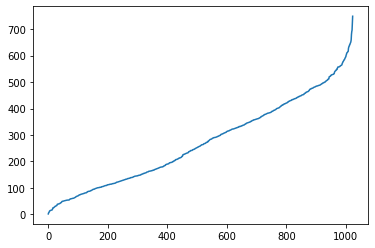

In [10]:
M, N = 4, 16
C_filter_random = 10*np.random.randn(N, N, M, 4)
#C_filter_random = create_weird_single_filter()
singular_values = clip_quaternionic_convolutional_layer(C_filter_random, None, None, just_compute_singular_values=True)
from matplotlib import pyplot as plt
plt.plot(singular_values)
plt.show()

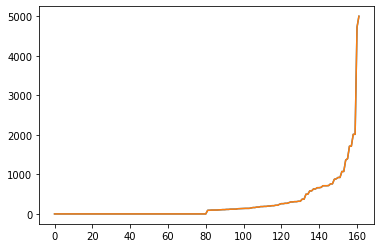

The absolute difference in computed singular values between using our method and an SVD over doubly-block circulant matrices is 7.948639719526269e-11


In [11]:
#C_filter_random = 10*np.random.randn(N, N, M, 4)
C_filter_random = create_weird_single_filter()
singular_values = clip_quaternionic_convolutional_layer(C_filter_random, None, None, just_compute_singular_values=True, xi_type='new')
singular_values_svd, C = clip_quaternionic_convolutional_layer(C_filter_random, None, None, just_compute_singular_values=True, bruteforce_svd=True)
from matplotlib import pyplot as plt
plt.plot(singular_values)
plt.plot(singular_values_svd)
plt.show()
#print(np.stack([singular_values, singular_values_svd], axis=1))
print(f'The absolute difference in computed singular values between using our method and an SVD over doubly-block circulant matrices is {np.sum(np.abs(singular_values - singular_values_svd))}')

(4096,)
12.134735373140762


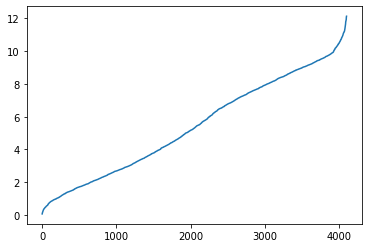

Runtime of 950 milliseconds.


In [12]:
from timeit import default_timer as timer
start = timer()
M = 4       # Number of inputs/outputs. Total number of filters will be M.
N = 32      # Filter size for one dimension. So each 2D filter will be sized NxN.
#C_filter_random = quaternion.from_float_array(10*np.random.randn(N,N,M,M,4))
C_filter_random = np.random.randn(3,3,M,4)

singular_values = clip_quaternionic_convolutional_layer(C_filter_random, N, None, just_compute_singular_values=True)
#singular_values_svd, C = clip_quaternionic_convolutional_layer(C_filter_random, N, None, just_compute_singular_values=True, bruteforce_svd=True)
from matplotlib import pyplot as plt
print(singular_values.shape)
#print(singular_values_svd.shape)
print(np.max(singular_values))
#print(np.max(singular_values_svd))
plt.plot(singular_values)
#plt.plot(singular_values_svd)
plt.show()
end = timer()
print(f'Runtime of {int((end - start) * 1000)} milliseconds.')

Runtime of 26 milliseconds.
125.09107688049016
30.000000000000036


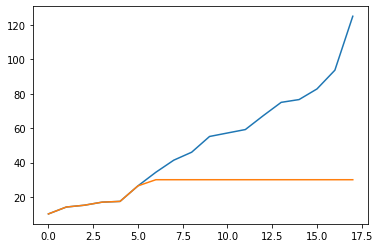

Runtime of 151 milliseconds.


In [14]:
from timeit import default_timer as timer
start = timer()
M = 2       # Number of inputs/outputs. Total number of filters will be M.
N = 3       # Filter size for one dimension. So each 2D filter will be sized NxN.
clipping_value = 30
##########################################################################################
from matplotlib import pyplot as plt
#C_filter_random = quaternion.from_float_array(10*np.random.randn(N,N,M,4))
C_filter_random = 10*np.random.randn(3,3,M,4)
#C_filter_random = 10*np.random.randn(N,N,M,4)
res, _, _ = clip_quaternionic_convolutional_layer(C_filter_random, inputimage_sidesize=N, clipping_value=clipping_value, return_floatarray=True)
svs_clipped_brute, res_brute = clip_quaternionic_convolutional_layer(C_filter_random, inputimage_sidesize=N, clipping_value=clipping_value, bruteforce_svd=True, return_floatarray=True)
end = timer()
print(f'Runtime of {int((end - start) * 1000)} milliseconds.')
#vis(quaternion.as_quat_array(C_filter_random[:, :, 1, :]))
#vis(res[:, :, 1])
#vis(res_brute)
svs_original = compute_singular_values(C_filter_random, inputimage_sidesize=N)
svs_clipped = compute_singular_values(res, inputimage_sidesize=N)
print(np.max(svs_original))
print(np.max(svs_clipped))
#print(np.max(svs_clipped_brute))
plt.plot(svs_original)
plt.plot(svs_clipped)
#plt.plot(svs_clipped_brute)
plt.show()
end = timer()
print(f'Runtime of {int((end - start) * 1000)} milliseconds.')